In [126]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import seaborn as sms
sms.set()

In [2]:
def r2_ajust(x,y):
    r = LinearRegression()
    r.fit(x,y)
    r2 = r.score(x,y)
    n = x.shape[0]
    p = x.shape[1]
    
    return 1-(1-r2)*(n-1)/(n-p-1)

In [3]:
def check_variable_distribution(df, check_variable, n_quantile=.99):
    dataframe = df.copy()
    
    n = dataframe.shape[0]
    max_variable = dataframe[check_variable].max()
    min_variable = dataframe[check_variable].min()
    range_value = max_variable - min_variable
    q3= min_variable + range_value*(3/5)
    f3= dataframe[dataframe[check_variable]<q3].shape[0]
    freq3 = f3/n

    
    if freq3 >= .8:
        q = dataframe[check_variable].quantile(n_quantile)
        dataframe1 = dataframe[dataframe[check_variable]<q]
    elif freq3<.3:
        q = dataframe[check_variable].quantile(1-n_quantile)
        dataframe1 = dataframe[dataframe[check_variable]>q]

    f, ax = plt.subplots(1,2,figsize=(19,8),sharey=True)
    sms.histplot(dataframe[check_variable],kde=True,ax=ax[0])
    sms.histplot(dataframe1[check_variable],kde=True,ax=ax[1])
    plt.show()
    
    return dataframe1

In [125]:
def generate_linearregression(x_train, y_train, x_test, y_test, log_y=False):
    reg = LinearRegression()
    reg.fit(x_train, y_train)
    print(f'R2 = {reg.score(x_train, y_train):.2f}')
    print(f'R2 Ajusted = {r2_ajust(x_train, y_train):.2f}')
    yhat_train = reg.predict(x_train)
    yhat_test = reg.predict(x_test)
    
    df_diff = pd.DataFrame()    
    if log_y:
        df_diff['Observed  - Train'] = np.exp(y_train)
        df_diff['Predicted - Train'] = np.exp(yhat_train)
    else:
        df_diff['Observed  - Train'] = y_train
        df_diff['Predicted - Train'] = yhat_train
    
    print(df_diff.describe(include='all'))
    
    df_diff = pd.DataFrame()    
    if log_y:
        df_diff['Observed  - Test'] = np.exp(y_test)
        df_diff['Predicted - Test'] = np.exp(yhat_test)
    else:
        df_diff['Observed  - Test'] = y_test
        df_diff['Predicted - Test'] = yhat_test
    
    print(df_diff.describe(include='all'))

    
    f, ax = plt.subplots(1,2,figsize=(19,8),sharey=True)
    if log_y:
        ax[0].plot(np.exp(y_train),np.exp(yhat_train),'.')
    else:
        ax[0].plot(y_train,yhat_train,'.')
    plt.ylabel('Predicted - Train')
    plt.xlabel('Observed - Train')
    
    if log_y:
        ax[1].plot(np.exp(y_test),np.exp(yhat_test),'.')
    else:
        ax[1].plot(y_test,yhat_test,'.')
    plt.ylabel('Predicted - Test')
    plt.xlabel('Observed - Test')
    plt.show()
    
    f, ax = plt.subplots(1,2,figsize=(19,8),sharey=True)
    ax[0].title.set_text('Observed - Train')
    ax[1].title.set_text('Predicted - Train')
    if log_y:
        sms.histplot(np.exp(y_train),kde=True,ax=ax[0])
        sms.histplot(np.exp(yhat_train),kde=True,ax=ax[1])
    else:
        sms.histplot(y_train,kde=True,ax=ax[0])
        sms.histplot(yhat_train,kde=True,ax=ax[1])
    plt.show()
    
    try:
        f, ax = plt.subplots(1,2,figsize=(19,8),sharey=True)
        ax[0].title.set_text('Observed - Test')
        ax[1].title.set_text('Predicted - Test')
        if log_y:
            sms.histplot(np.exp(y_test),kde=True,ax=ax[0])
            sms.histplot(np.exp(yhat_test),kde=True,ax=ax[1])
        else:
            sms.histplot(y_test,kde=True,ax=ax[0])
            sms.histplot(yhat_test,kde=True,ax=ax[1])
        plt.show()
    except Exception as ex:
        print(ex)
    return reg
    

In [84]:
def drop_highpvalues(x_train, y_train, x_test, y_test, limit_pvalue=.1):
    variables = x_train.copy()
    variables_test = x_test.copy()
    reg = LinearRegression()
    reg.fit(x_train, y_train)
    df_p = pd.DataFrame()
    df_p['Features'] = variables.columns.values
    df_p['Weigths'] = reg.coef_
    df_p['p-value'] = f_regression(variables, y_train)[1].round(3)
    drop_columns = df_p[df_p['p-value']>limit_pvalue]['Features'].values
    variables.drop(drop_columns,axis=1,inplace=True)
    variables_test.drop(drop_columns,axis=1,inplace=True)
    print(f'Dropped {drop_columns.shape[0]} Features')
    print(drop_columns)
    
    return variables,variables_test

In [7]:
def generate_summary(x,y):
    reg = LinearRegression()
    reg.fit(x,y)
    df_summary = pd.DataFrame()
    df_summary['Features'] = x.columns.values
    df_summary['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    for i in range(x.shape[1]):
        variance_inflation_factor(x.values, i)
    df_summary['Weigths'] = reg.coef_
    df_summary['p-value'] = f_regression(x,y)[1].round(3)
    
    print(df_summary.describe(include='all'))

### Import Data

In [8]:
pathfile = '1.04.+Real-life+example.csv'
raw_data = pd.read_csv(pathfile)
raw_data.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


### Cleaning Data

In [9]:
data_nonan = raw_data.dropna()
data_nonan.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4025,4025.000000,4025,4025.000000,4025.000000,4025,4025,4025.000000,4025
unique,7,NaN,6,NaN,NaN,4,2,NaN,306
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,880,NaN,1534,NaN,NaN,1861,3654,NaN,188
mean,NaN,19552.308065,NaN,163.572174,2.764586,NaN,NaN,2006.379627,NaN
std,NaN,25815.734988,NaN,103.394703,4.935941,NaN,NaN,6.695595,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,90.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,158.000000,2.200000,NaN,NaN,2007.000000,NaN
75%,NaN,21900.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


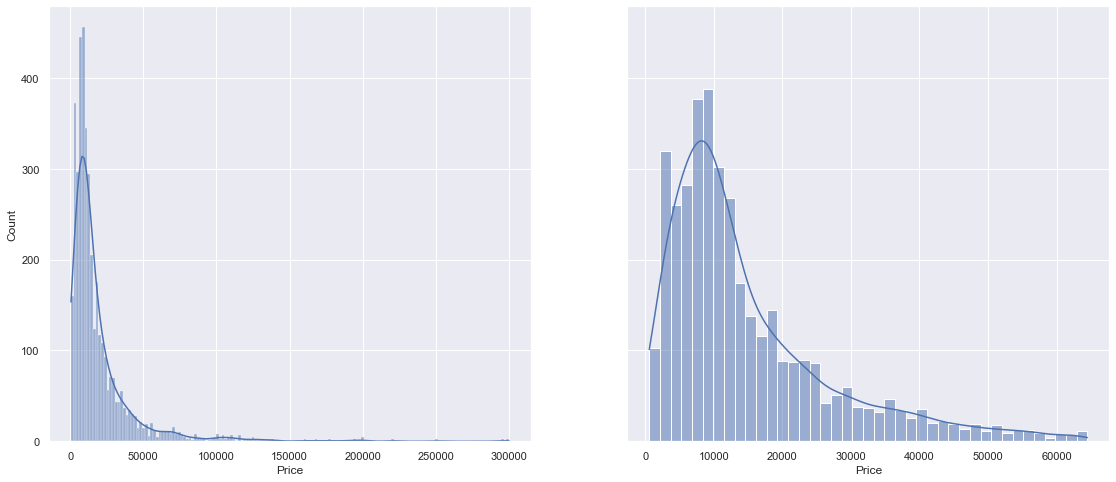

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,3823,3823.000000,3823,3823.000000,3823.000000,3823,3823,3823.000000,3823
unique,7,NaN,6,NaN,NaN,4,2,NaN,294
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,872,NaN,1491,NaN,NaN,1740,3452,NaN,188
mean,NaN,14911.796798,NaN,171.095998,2.715250,NaN,NaN,2005.934868,NaN
std,NaN,12198.369515,NaN,99.269432,5.052605,NaN,NaN,6.565549,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6800.000000,NaN,100.000000,1.800000,NaN,NaN,2002.000000,NaN
50%,NaN,10900.000000,NaN,163.000000,2.000000,NaN,NaN,2007.000000,NaN
75%,NaN,19150.000000,NaN,234.000000,3.000000,NaN,NaN,2011.000000,NaN


In [10]:
check_variable = 'Price'
n_quantile = .95
data1 = check_variable_distribution(data_nonan, check_variable, n_quantile=n_quantile)
data1.describe(include='all')

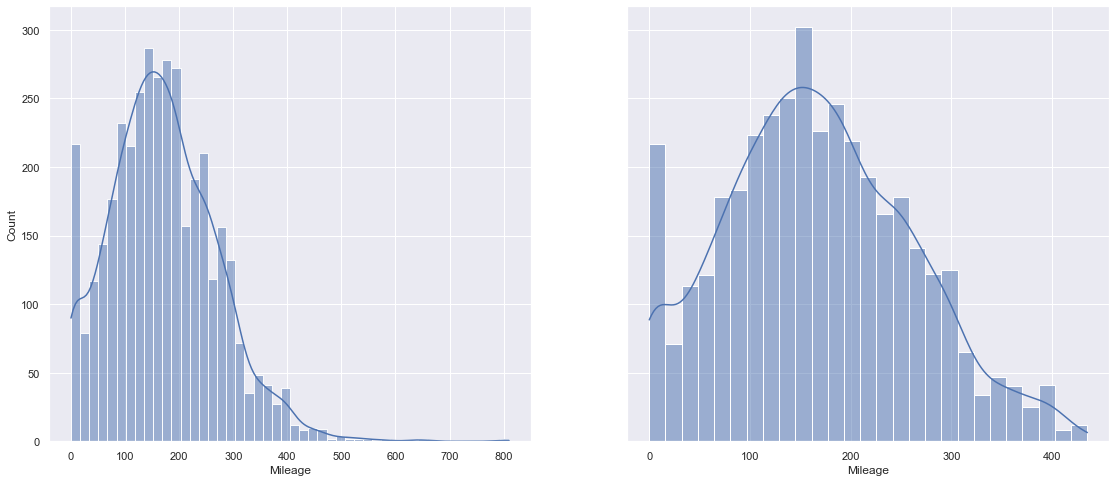

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,3823,3823.000000,3823,3823.000000,3823.000000,3823,3823,3823.000000,3823
unique,7,NaN,6,NaN,NaN,4,2,NaN,294
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,872,NaN,1491,NaN,NaN,1740,3452,NaN,188
mean,NaN,14911.796798,NaN,171.095998,2.715250,NaN,NaN,2005.934868,NaN
std,NaN,12198.369515,NaN,99.269432,5.052605,NaN,NaN,6.565549,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6800.000000,NaN,100.000000,1.800000,NaN,NaN,2002.000000,NaN
50%,NaN,10900.000000,NaN,163.000000,2.000000,NaN,NaN,2007.000000,NaN
75%,NaN,19150.000000,NaN,234.000000,3.000000,NaN,NaN,2011.000000,NaN


In [11]:
check_variable = 'Mileage'
n_quantile = .99
data2 = check_variable_distribution(data1, check_variable, n_quantile=n_quantile)
data1.describe(include='all')

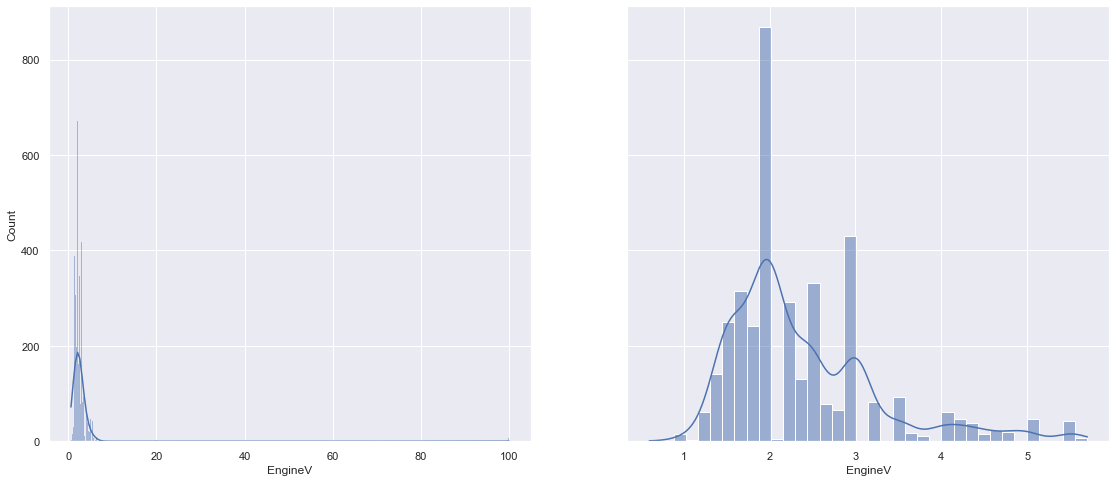

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,3741,3741.000000,3741,3741.000000,3741.000000,3741,3741,3741.000000,3741
unique,7,NaN,6,NaN,NaN,4,2,NaN,283
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,854,NaN,1451,NaN,NaN,1705,3379,NaN,185
mean,NaN,14947.346474,NaN,167.569099,2.381681,NaN,NaN,2006.044640,NaN
std,NaN,12147.910092,NaN,93.261910,0.877525,NaN,NaN,6.500875,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6900.000000,NaN,100.000000,1.800000,NaN,NaN,2002.000000,NaN
50%,NaN,10950.000000,NaN,161.000000,2.000000,NaN,NaN,2007.000000,NaN
75%,NaN,19200.000000,NaN,230.000000,2.900000,NaN,NaN,2011.000000,NaN


In [12]:
check_variable = 'EngineV'
n_quantile = .99
data3 = check_variable_distribution(data2, check_variable, n_quantile=n_quantile)
data3.describe(include='all')

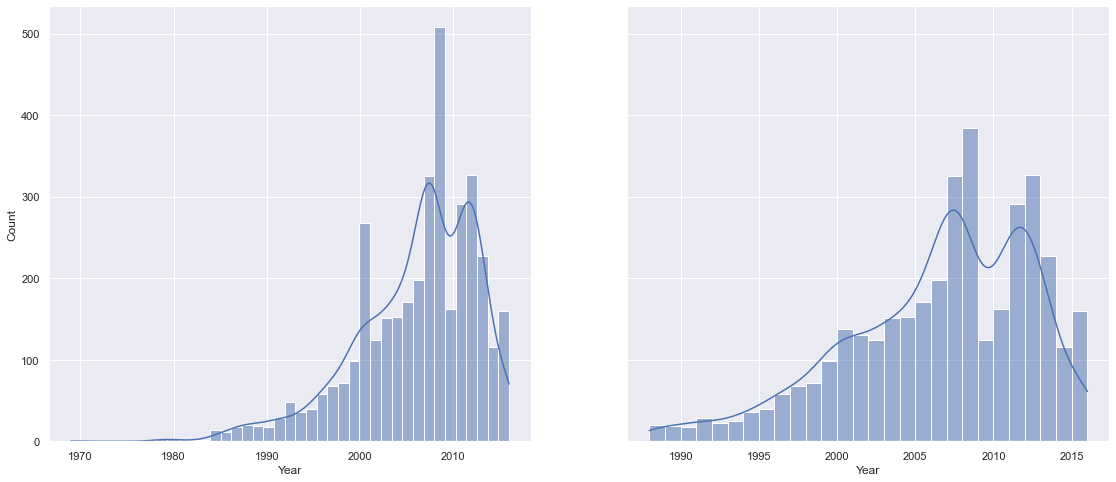

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,3687,3687.000000,3687,3687.000000,3687.000000,3687,3687,3687.000000,3687
unique,7,NaN,6,NaN,NaN,4,2,NaN,276
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,840,NaN,1419,NaN,NaN,1694,3325,NaN,181
mean,NaN,15118.899731,NaN,166.887985,2.388058,NaN,NaN,2006.358015,NaN
std,NaN,12140.158199,NaN,92.799770,0.880550,NaN,NaN,5.993065,NaN
min,NaN,800.000000,NaN,0.000000,0.600000,NaN,NaN,1988.000000,NaN
25%,NaN,7000.000000,NaN,100.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11000.000000,NaN,160.000000,2.000000,NaN,NaN,2007.000000,NaN
75%,NaN,19500.000000,NaN,230.000000,2.995000,NaN,NaN,2011.000000,NaN


In [13]:
check_variable = 'Year'
n_quantile = .99
data4 = check_variable_distribution(data3, check_variable, n_quantile=n_quantile)
data4.describe(include='all')

In [122]:
data_cleaned = data4.reset_index(drop=True)
#data_cleaned.drop(['Model'],axis=1,inplace=True)
data_cleaned.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


### Creating Dummies columns

In [123]:
data_with_dummies = pd.get_dummies(data_cleaned, drop_first=True)
data_with_dummies.describe(include='all')

,Price,Mileage,EngineV,Year,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,...,Model_Vito,Model_X1,Model_X3,Model_X5,Model_X5 M,Model_X6,Model_X6 M,Model_Yaris,Model_Z3,Model_Z4
count,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,...,3687.000000,3687.000000,3687.000000,3687.00000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000,3687.000000
mean,15118.899731,166.887985,2.388058,2006.358015,0.155411,0.182533,0.081909,0.117168,0.129373,0.227828,...,0.041768,0.002983,0.002983,0.02441,0.001356,0.007865,0.000271,0.003797,0.000271,0.001356
std,12140.158199,92.799770,0.880550,5.993065,0.362345,0.386336,0.274264,0.321665,0.335658,0.419488,...,0.200087,0.054547,0.054547,0.15434,0.036805,0.088350,0.016469,0.061512,0.016469,0.036805
min,800.000000,0.000000,0.600000,1988.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7000.000000,100.000000,1.800000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,11000.000000,160.000000,2.000000,2007.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,19500.000000,230.000000,2.995000,2011.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,64500.000000,435.000000,5.700000,2016.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### NO Performing feature selection

### Linear Regression drop high p values - Transform Price in log values

--> Removing High P-Value Features
Dropped 144 Features
['Model_116' 'Model_118' 'Model_120' 'Model_210' 'Model_220' 'Model_323'
 'Model_325' 'Model_328' 'Model_330' 'Model_335' 'Model_523' 'Model_528'
 'Model_530' 'Model_540' 'Model_545' 'Model_630' 'Model_645' 'Model_650'
 'Model_730' 'Model_735' 'Model_740' 'Model_745' 'Model_A1' 'Model_A3'
 'Model_A6 Allroad' 'Model_A8' 'Model_ASX' 'Model_Amarok' 'Model_Auris'
 'Model_Avalon' 'Model_Avensis' 'Model_Aygo' 'Model_B 170' 'Model_B 180'
 'Model_B 200' 'Model_Beetle' 'Model_Bora' 'Model_C-Class' 'Model_CL 500'
 'Model_CL 550' 'Model_CLC 200' 'Model_CLK 200' 'Model_CLK 220'
 'Model_CLK 240' 'Model_CLK 280' 'Model_CLK 320' 'Model_CLK 430'
 'Model_Captur' 'Model_Caravelle' 'Model_Celica' 'Model_Cross Touran'
 'Model_Dokker' 'Model_Duster' 'Model_E-Class' 'Model_Eclipse' 'Model_Eos'
 'Model_Fluence' 'Model_Fortuner' 'Model_G 320' 'Model_G 63 AMG'
 'Model_GL 420' 'Model_GL 450' 'Model_GL 550' 'Model_Golf Plus'
 'Model_Golf V' 'Model_Golf VI' 

C:\Users\Luccas\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
<ipython-input-125-7e321e6d420a>:22: RuntimeWarning: overflow encountered in exp
  df_diff['Predicted - Test'] = np.exp(yhat_test)
<ipython-input-125-7e321e6d420a>:39: RuntimeWarning: overflow encountered in exp
  ax[1].plot(np.exp(y_test),np.exp(yhat_test),'.')


       Observed  - Train  Predicted - Train
count        2949.000000        2949.000000
mean        15252.519057       14732.185906
std         12296.902090       10730.734074
min           800.000000         999.031504
25%          7000.000000        7043.982529
50%         11000.000000       11517.914552
75%         19900.000000       19779.560386
max         64500.000000       63842.915826
       Observed  - Test  Predicted - Test
count        738.000000      7.380000e+02
mean       14584.965596               inf
std        11484.993066               NaN
min         1200.000000      0.000000e+00
25%         6992.250000      7.173510e+03
50%        11107.500000      1.199878e+04
75%        18500.000000      1.998416e+04
max        63333.000000               inf


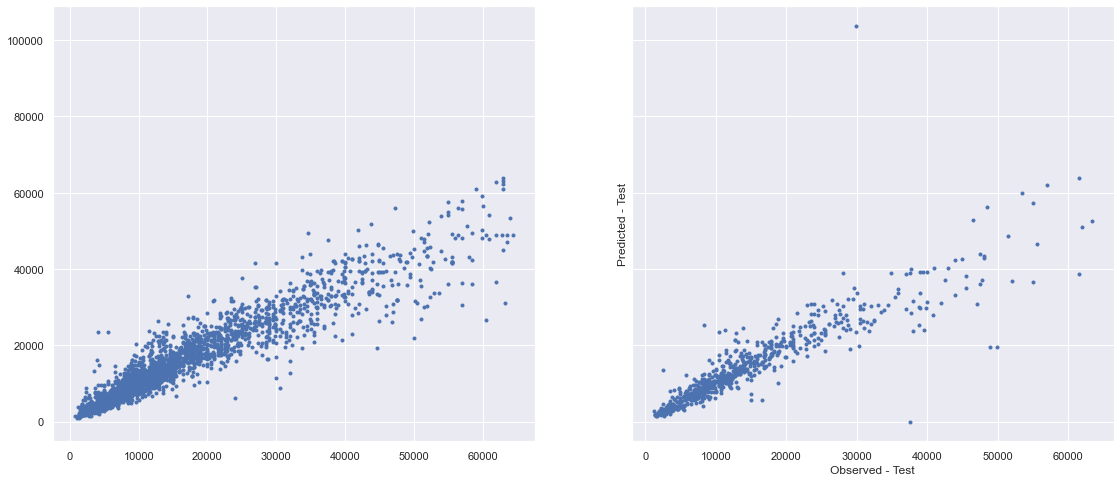

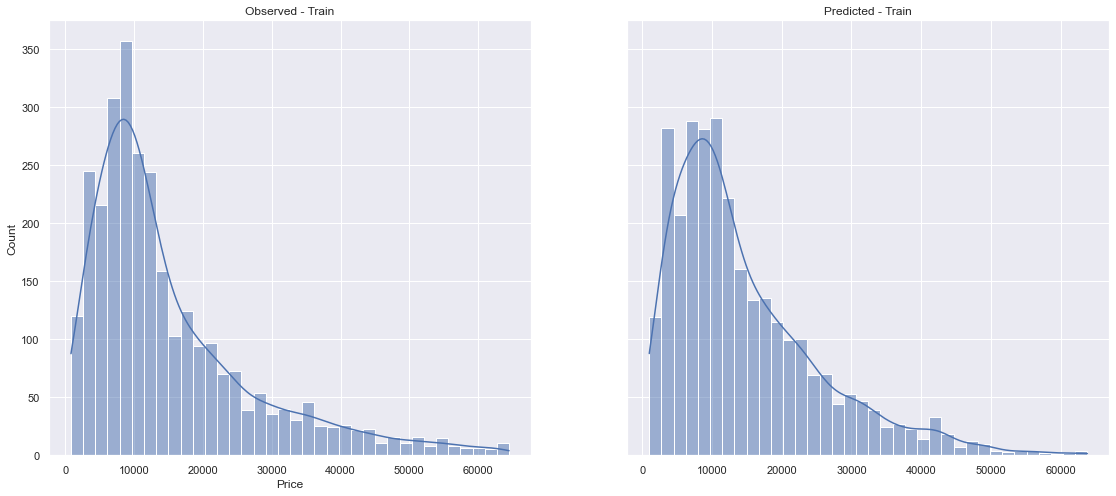

<ipython-input-125-7e321e6d420a>:63: RuntimeWarning: overflow encountered in exp
  sms.histplot(np.exp(yhat_test),kde=True,ax=ax[1])
C:\Users\Luccas\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


autodetected range of [0.0, inf] is not finite
--> Summary of the Linear Regression


C:\Users\Luccas\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\Luccas\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\Luccas\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Luccas\anaconda3\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


         Features         VIF       Weigths     p-value
count         293  271.000000  2.930000e+02  271.000000
unique        293         NaN           NaN         NaN
top     Model_550         NaN           NaN         NaN
freq            1         NaN           NaN         NaN
mean          NaN         inf -6.668078e+06    0.287967
std           NaN         NaN  8.935680e+08    0.321398
min           NaN    1.191751 -4.497762e+09    0.000000
25%           NaN    5.132673 -1.379419e+07    0.002000
50%           NaN  555.588496  1.235378e+00    0.133000
75%           NaN         NaN  2.218756e+00    0.552000
max           NaN         inf  2.283003e+09    0.966000


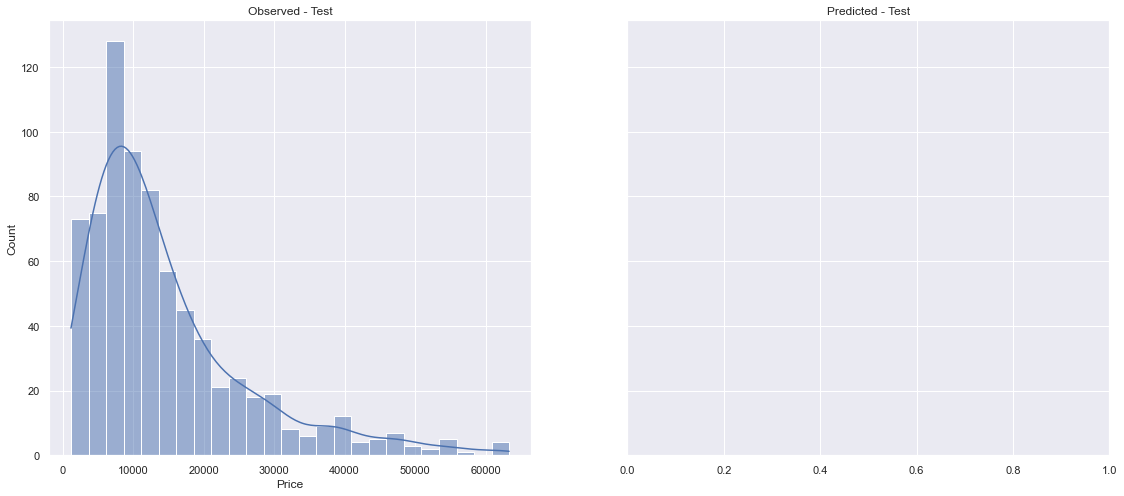

In [127]:
data_train, data_test = train_test_split(data_with_dummies, test_size=0.2, random_state=365)
data_train.reset_index(drop=True,inplace=True)
data_test.reset_index(drop=True,inplace=True)

y_train = np.log(data_train['Price'])
x_train = data_train.drop(['Price'],axis=1)

y_test = np.log(data_test['Price'])
x_test = data_test.drop(['Price'],axis=1)

print('--> Removing High P-Value Features')
x1_train, x1_test = drop_highpvalues(x_train, y_train, x_test, y_test, limit_pvalue=.1)

print('--> Generating Linear Regression Infomation')
generate_linearregression(x1_train, y_train, x1_test, y_test, log_y = True)

print('--> Summary of the Linear Regression')
generate_summary(x_train, y_train)

The model is overfitting the training data. We can see the way that he fits too well in the training data but have a lot of problems in the estimaton of test data.
Add the Feature 'Model' of car increase the R2 but bring a lot of problems to the estimation in testing data. This happends beacuse of there is a lot of different Car Models and their frequency as very low.
Therefore is better to drop 'Model' Feature from the Model.